# Predicting Energy Efficiency With Regression

In [12]:
# Please load packages before continuing:
library(tidyverse)
library(readxl)
library(repr) # for visualization
library(tidymodels)
library(cowplot)
library(GGally)
options(repr.matrix.max.rows = 6)
set.seed(1)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



## Introduction

**Background Information**

The heating load of a building is "the amount of heat energy" needed "to maintain the temperature in an acceptable range" (Government of Australia).
A higher heating load correlates to more heat energy required, which is detrimental to the environment, and has a higher monetary cost.
We aim to study how various factors such as surface area, overall height, and glazing area (ie. size of windows) affects the heating load of buildings. We define more energy-efficient buildings as buildings that require lower heating loads.

**Question**

What is the heating load (energy-efficiency) for a building with a given surface area, overall height, and glazing area?

**Dataset Description**

We're using the "Energy Efficiency Data Set" created at the University of Oxford (Xifara, Tsanas).
It contains eight attributes and two outcomes which are the column headers of the tibble below. Initially, all columns were labelled X1, X2, etc. instead of their corresponding descriptive names. The dataset has 768 rows and was generated through computer simulation. All observations (buildings) have the same volume, thus we can evaluate the effect of predictors independent of volume.

## Preliminary Exploratory Data Analysis

**Reading Data Set into R and Tidying (changing column names)**

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
file_name <- "energy-efficiency.xlsx"
download.file(url, file_name)
energy_data <- read_excel(file_name, 
                          skip = 1, 
                          col_names = c("Relative.Compactness", "Surface.Area", "Wall.Area", 
                                        "Roof.Area", "Overall.Height", "Orientation", 
                                        "Glazing.Area", "Glazing.Area.Distribution", 
                                        "Heating.Load", "Cooling.Load"))
energy_data

Relative.Compactness,Surface.Area,Wall.Area,Roof.Area,Overall.Height,Orientation,Glazing.Area,Glazing.Area.Distribution,Heating.Load,Cooling.Load
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.98,514.5,294,110.25,7,2,0,0,15.55,21.33
0.98,514.5,294,110.25,7,3,0,0,15.55,21.33
0.98,514.5,294,110.25,7,4,0,0,15.55,21.33
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.62,808.5,367.5,220.5,3.5,3,0.4,5,16.44,17.11
0.62,808.5,367.5,220.5,3.5,4,0.4,5,16.48,16.61
0.62,808.5,367.5,220.5,3.5,5,0.4,5,16.64,16.03


**Cleaning and Wrangling Data**

In [3]:
#Table with variables that we will be using in our analysis
energy_data_reduced <- energy_data |>
                    select(Surface.Area, Overall.Height, Glazing.Area, Heating.Load)
energy_data_reduced

Surface.Area,Overall.Height,Glazing.Area,Heating.Load
<dbl>,<dbl>,<dbl>,<dbl>
514.5,7,0,15.55
514.5,7,0,15.55
514.5,7,0,15.55
⋮,⋮,⋮,⋮
808.5,3.5,0.4,16.44
808.5,3.5,0.4,16.48
808.5,3.5,0.4,16.64


In [4]:
energy_split <- initial_split(energy_data, prop = 0.75, strata = Heating.Load)
energy_train <- training(energy_split)
energy_test <- testing(energy_split)

**Data Summarization (only training data)**

In [5]:
# Mean Table
energy_data_mean <- summarize(energy_train,
    Surface.Area.Mean = mean(Surface.Area),                   
    Overall.Height.Mean = mean(Overall.Height),                        
    Glazing.Area.Mean = mean(Glazing.Area),                            
    Heating.Load.Mean = mean(Heating.Load))

# Median Table
energy_data_median <- summarize(energy_train,
    Surface.Area.Median = median(Surface.Area),                   
    Overall.Height.Median = median(Overall.Height),                        
    Glazing.Area.Median = median(Glazing.Area),  
    Heating.Load.Median = median(Heating.Load))

# finding mode
heating_mode <- names(sort(-table(energy_train$Heating.Load)))[1]
surface_mode <- names(sort(-table(energy_train$Surface.Area)))[1]
height_mode <- names(sort(-table(energy_train$Overall.Height)))[1]
glazing_mode <- names(sort(-table(energy_train$Glazing.Area)))[1]

# Mode Table
energy_data_mode <- summarize(energy_train,
                        Surface.Area.Mode = surface_mode,
                        Overall.Height.Mode = height_mode,
                        Glazing.Area.Mode = glazing_mode,
                        Heating.Load.Mode = heating_mode)

# Max Table
energy_data_max <- summarize(energy_train,
    Surface.Area.Max = max(Surface.Area),                   
    Overall.Height.Max = max(Overall.Height),                        
    Glazing.Area.Max = max(Glazing.Area),  
    Heating.Load.Max = max(Heating.Load))

# Min Table
energy_data_min <- summarize(energy_train,
    Surface.Area.Min = min(Surface.Area),                   
    Overall.Height.Min = min(Overall.Height),                        
    Glazing.Area.Min = min(Glazing.Area),  
    Heating.Load.Min = min(Heating.Load))

# Number of Rows Missing Data
num_rows_missing_data <- energy_train |>
                        filter(Surface.Area == NA | 
                               Overall.Height == NA | Glazing.Area == NA | Heating.Load == NA) |>
                        nrow() |>
                        as_tibble()
colnames(num_rows_missing_data) <- c("Number.Of.Rows.Missing.Data")

energy_data_mean
energy_data_median
energy_data_mode
energy_data_max
energy_data_min
num_rows_missing_data

Surface.Area.Mean,Overall.Height.Mean,Glazing.Area.Mean,Heating.Load.Mean
<dbl>,<dbl>,<dbl>,<dbl>
672.8568,5.231771,0.2396701,22.3072


Surface.Area.Median,Overall.Height.Median,Glazing.Area.Median,Heating.Load.Median
<dbl>,<dbl>,<dbl>,<dbl>
686,3.5,0.25,18.95


Surface.Area.Mode,Overall.Height.Mode,Glazing.Area.Mode,Heating.Load.Mode
<chr>,<chr>,<chr>,<chr>
759.5,3.5,0.4,10.68


Surface.Area.Max,Overall.Height.Max,Glazing.Area.Max,Heating.Load.Max
<dbl>,<dbl>,<dbl>,<dbl>
808.5,7,0.4,43.1


Surface.Area.Min,Overall.Height.Min,Glazing.Area.Min,Heating.Load.Min
<dbl>,<dbl>,<dbl>,<dbl>
514.5,3.5,0,6.05


Number.Of.Rows.Missing.Data
<int>
0


**Data Visualization (only training data)**

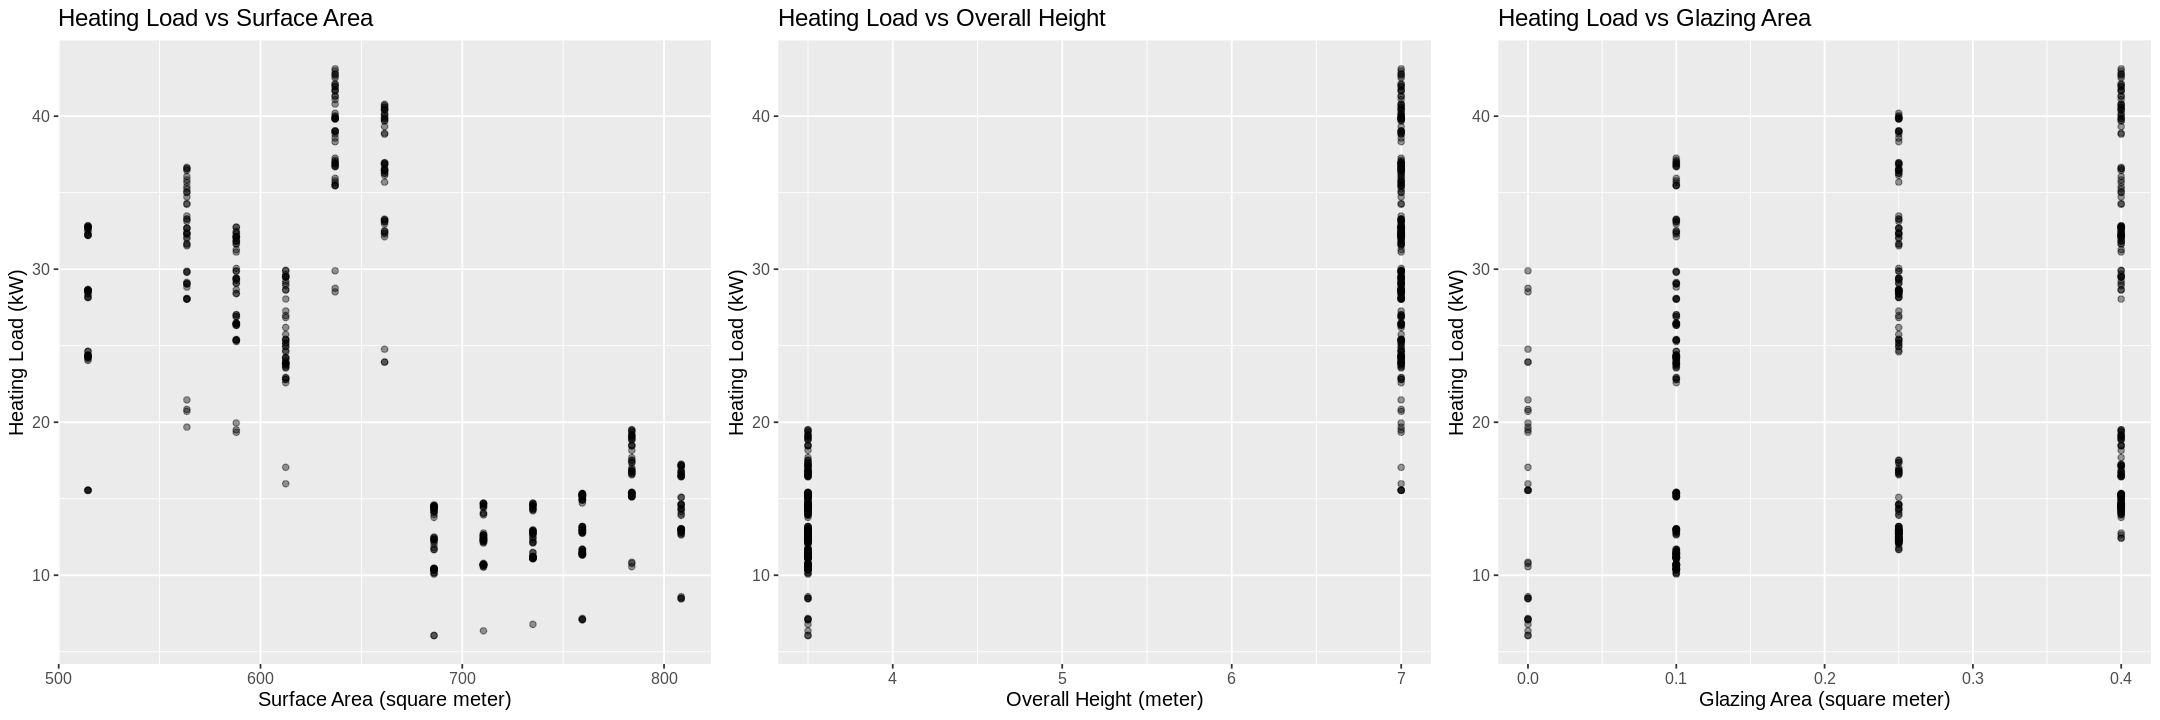

In [6]:
options(repr.plot.width=18, repr.plot.height=6)
plot_surface <- ggplot(energy_train, aes(x = Surface.Area, y = Heating.Load)) +
    geom_point(alpha = 0.4) +
    labs(x = "Surface Area (square meter)", y = "Heating Load (kW)") +
    theme(text = element_text(size = 12)) +
    ggtitle("Heating Load vs Surface Area")
plot_height <- ggplot(energy_train, aes(x = Overall.Height, y = Heating.Load)) +
    geom_point(alpha = 0.4) +
    labs(x = "Overall Height (meter)", y = "Heating Load (kW)") +
    theme(text = element_text(size = 12)) +
    ggtitle("Heating Load vs Overall Height")
plot_glazing <- ggplot(energy_train, aes(x = Glazing.Area, y = Heating.Load)) +
    geom_point(alpha = 0.4) +
    labs(x = "Glazing Area (square meter)", y = "Heating Load (kW)") +
    theme(text = element_text(size = 12)) +
    ggtitle("Heating Load vs Glazing Area")
plot_grid(plot_surface, plot_height, plot_glazing, nrow = 1)

**Interpretation of Visualizations**

Our first plot doesn’t show a continuous linear pattern. The relationship changes from negative to positive around the middle, where the Heating Load drops and starts to increase more gradually. This change may indicate a more energy-efficient Surface Area around its median, whereas considering the jumps at ~635 m^2, and ~785 m^2 (where afterwards the relationship changes direction), it could also mean that other predictor variables are having an effect on Heating Load.

For our other two plots, both Overall Height and Glazing Area have a positive linear relationship with Heating Load. Differently from Overall Height, when Glazing Area is 0 m^2, the Heating Load is distributed across a wider range, thus at 0 m^2 other predictor variables may have a greater effect on Heating Load. In most of our visualizations, the Heating Load values are widely distributed for a single predictor variable value, which could mean that other variables are having an effect.

## Methods

We'll tidy the data, find summary statistics and number of rows missing data.

We'll use the variables Surface Area, Overall Height, and Glazing Area as they affect the heating load most significantly.

We won't use Relative Compactness because the dataset didn't explain what it means; the Roof Area and Wall Area because they're encompassed within Surface Area; Orientation because it’s a categorical variable, which can have too much of an impact on regression analysis and the categories ("2", "3", "4", "5") are not defined; and Glazing Area Distribution since it's similar to Glazing Area.

We'll visualize our training data using only our chosen variables to interpret their relationships with Heating Load.

We'll center and scale the data and then use both K-nearest neighbours and linear regression to see which is more accurate for our data. We'll use cross validation to find the best value of k and set the seed to ensure reproducibility. Then, visualize the results with one scatter plot for each variable (predictor on x-axis, heating load on y-axis).

We choose "heating load" because in Vancouver, we need to keep buildings warm due to cold winters.

## Expected Outcomes and Significance

**What do we expect to find?**

From our initial visualizations, we expect Heating Load to be proportional to Overall Height and Glazing Area, whereas the relationship between Heating Load and Surface Area is unclear for now.

**What impact could such findings have?**

Our findings could help architects determine the heating load of future buildings to make energy-efficient design decisions, saving cost and mitigating climate change.

**What future questions could this lead to?**

Does the cooling load of the building also have a similar relationship with our predictor variables?
Do external factors/variables that are not considered (eg. climate, humidity) also affect the heating load of a building?

In [7]:
#K-NN REGRESSION


data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>  #TUNING
       set_engine("kknn") |>
       set_mode("regression") 

data_recipe <- recipe(Heating.Load ~ Surface.Area + Overall.Height + Glazing.Area, 
                      data = energy_train) |>                                    
                      step_scale(all_predictors()) |> #SCALING AND CENTERING
                      step_center(all_predictors())

data_vfold <- vfold_cv(energy_train, v = 5, strata = Heating.Load)

data_workflow <- workflow() |>
    add_recipe(data_recipe) |>
    add_model(data_spec)

gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 10)) #TESTING K VALUES

data_results <- data_workflow |>
  tune_grid(resamples = data_vfold, grid = gridvals) |>
  collect_metrics()   

data_min <- data_results |>
    filter(.metric == "rmse") |>
    arrange(mean) |> 
    head(n=1)

k_min <- data_min |>
          pull(neighbors)

data_best_spec <- nearest_neighbor(weight_func = "rectangular", 
                                   neighbors = k_min) |>  #NOW WITH BEST K (MINIMUM RMSPE)
          set_engine("kknn") |>
          set_mode("regression")

data_fit <- workflow() |>
          add_recipe(data_recipe) |>
          add_model(data_best_spec) |>
          fit(data = energy_train)

data_summary <- data_fit |>
           predict(energy_test) |>
           bind_cols(energy_test) |>
           metrics(truth = Heating.Load, estimate = .pred) |>
           filter(.metric == "rmse")

           #select(.estimate) |>
           #pull()

data_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.688958


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
   (Intercept)    Surface.Area  Overall.Height    Glazing.Area  
     -51.84965         0.04691         7.17125        21.17462  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.102325
rsq,standard,0.905735
mae,standard,2.347605


Warning message:
“`pull_workflow_fit()` was deprecated in workflows 0.2.3.
Please use `extract_fit_parsnip()` instead.”


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-51.8496486,2.646725681,-19.59011,8.993932e-66
Surface.Area,0.0469098,0.002896025,16.19800,7.560748e-49
Overall.Height,7.1712520,0.145753209,49.20133,1.064580e-207
Glazing.Area,21.1746195,0.964770930,21.94782,6.449536e-78


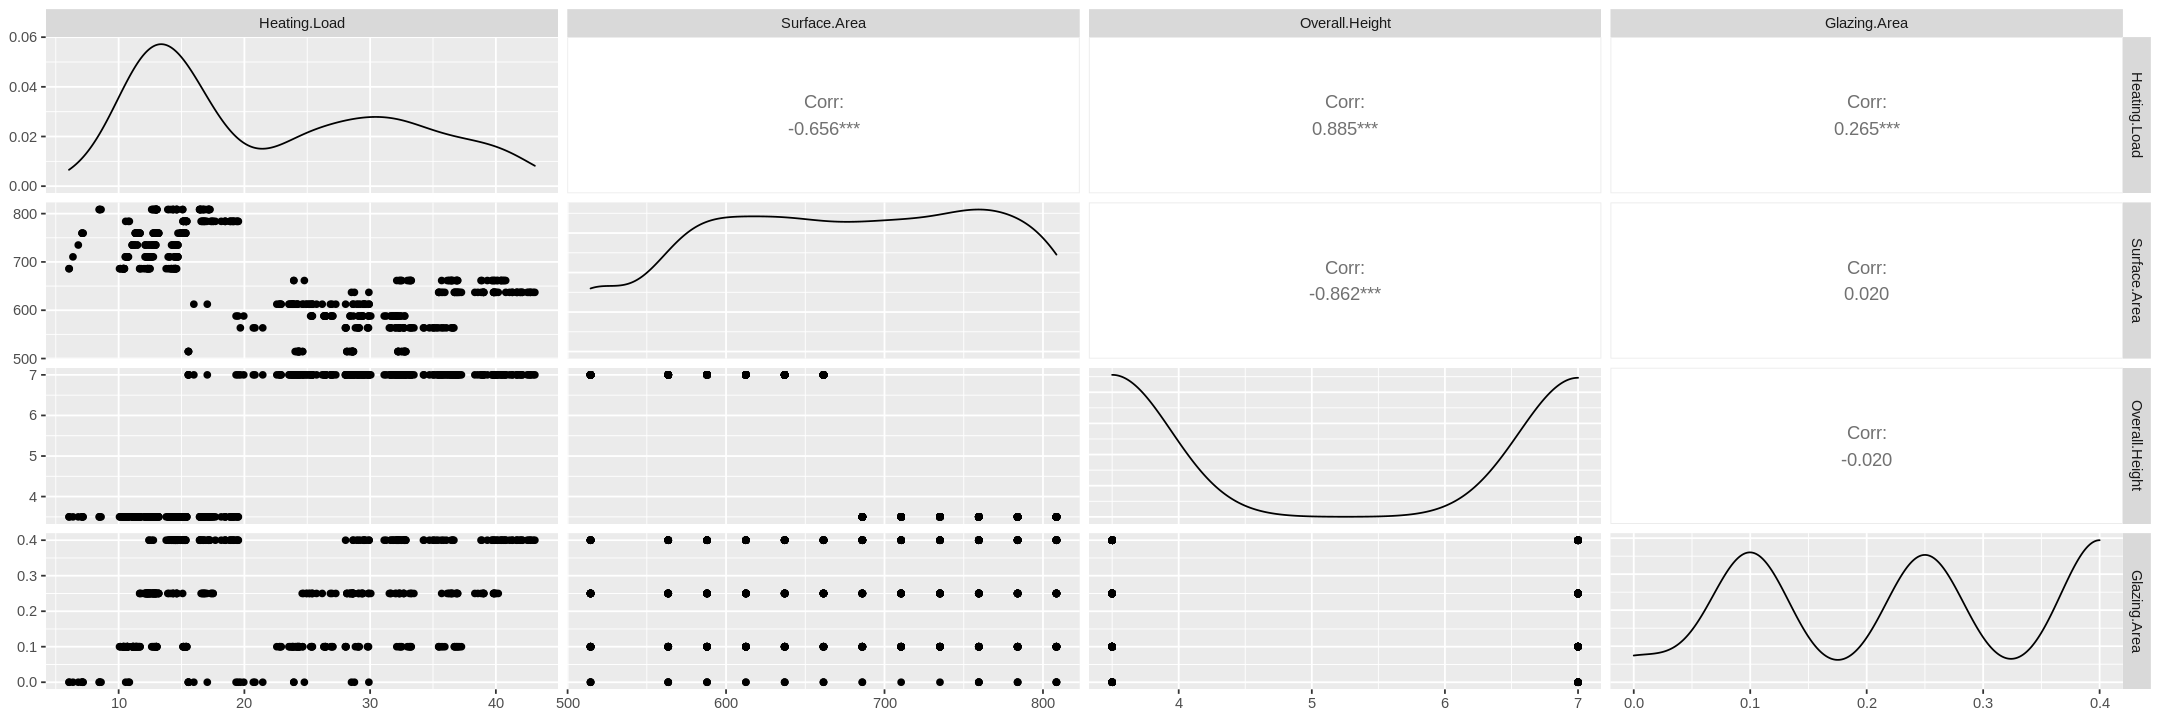

In [14]:
# LINEAR REGRESSION
lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(Heating.Load ~ Surface.Area + Overall.Height + Glazing.Area, data = energy_train)

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = energy_train)
lm_fit
lm_test_results <- lm_fit |>
    predict(energy_test) |>
    bind_cols(energy_test) |>
    metrics(truth = Heating.Load, estimate = .pred)
lm_test_results

# lm_plot_final <- ggplot(energy_train, aes(x=Surface.Area ??? how to best graph out multiple variables?)
# it seems that we cannot make visualization in 2dif we are using 3 predicting variables
energy_train_used_columns <- select(energy_train, Heating.Load, Surface.Area, Overall.Height, Glazing.Area)
lm_plot <- ggpairs(energy_train_used_columns)
lm_plot

lm_coefficients <- lm_fit |>
    pull_workflow_fit() |>
    tidy()
lm_coefficients

# Heating Load = -51.84965 + 0.04691 * (Surface Area) + 7.17125 * (Overall Height) + 21.17462 * (Glazing Area)
# (data from lm_test_results)

## Citations

Government of Australia: https://basix.nsw.gov.au/iframe/thermal-help/heating-and-cooling-loads.html#:~:text=The%20heating%20load%20is%20the,temperature%20in%20an%20acceptable%20range

Dataset (Xifara, Tsanas): https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

https://basix.nsw.gov.au/iframe/thermal-help/heating-and-cooling-loads.html#:~:text=The%20heating%20load%20is%20the,temperature%20in%20an%20acceptable%20range.
https://www.plumbersstock.com/how-to-hvac/calculate-heat-load.html